------
### Metis: Project McNulty 
>  Neha Gupta                
>  Date: 02/13/2019
-------

### Import Libraries

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

#### Upload Files through Spark

__Upload bids file__

In [45]:
df_bids = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/Users/admin/Downloads/facebook-recruiting-iv-human-or-bot/bids.csv')
df_bids.createOrReplaceTempView('bids')

spark.sql('select * from bids limit 5').show()

spark.sql('select count(*) from bids').show()

+------+--------------------+-------+-----------+------+----------------+-------+--------------+---------------+
|bid_id|           bidder_id|auction|merchandise|device|            time|country|            ip|            url|
+------+--------------------+-------+-----------+------+----------------+-------+--------------+---------------+
|     0|8dac2b259fd1c6d11...|  ewmzr|    jewelry|phone0|9759243157894736|     us| 69.166.231.58|vasstdc27m7nks3|
|     1|668d393e858e81262...|  aeqok|  furniture|phone1|9759243157894736|     in| 50.201.125.84|jmqlhflrzwuay9c|
|     2|aa5f360084278b35d...|  wa00e| home goods|phone2|9759243157894736|     py|112.54.208.157|vasstdc27m7nks3|
|     3|3939ac3ef7d472a59...|  jefix|    jewelry|phone4|9759243157894736|     in| 18.99.175.133|vasstdc27m7nks3|
|     4|8393c48eaf4b8fa96...|  jefix|    jewelry|phone5|9759243157894736|     in|  145.138.5.37|vasstdc27m7nks3|
+------+--------------------+-------+-----------+------+----------------+-------+--------------+

__Upload train file__

In [46]:
df_train = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/Users/admin/Downloads/facebook-recruiting-iv-human-or-bot/train.csv')
df_train.createOrReplaceTempView('train')

spark.sql('select * from train limit 5').show()

spark.sql('select count(*) from train').show()

+--------------------+--------------------+--------------------+-------+
|           bidder_id|     payment_account|             address|outcome|
+--------------------+--------------------+--------------------+-------+
|91a3c57b13234af24...|a3d2de7675556553a...|a3d2de7675556553a...|    0.0|
|624f258b49e77713f...|a3d2de7675556553a...|ae87054e5a97a8f84...|    0.0|
|1c5f4fc669099bfbf...|a3d2de7675556553a...|92520288b50f03907...|    0.0|
|4bee9aba2abda51bf...|51d80e233f7b6a7df...|4cb9717c8ad7e88a9...|    0.0|
|4ab12bc61c82ddd9c...|a3d2de7675556553a...|2a96c3ce94b3be921...|    0.0|
+--------------------+--------------------+--------------------+-------+

+--------+
|count(1)|
+--------+
|    2013|
+--------+



# Features Extraction

__Feature of counts: Counts of distinct values for a bidder__

In [47]:
feature_of_counts= spark.sql('''
select 
    bidder_id,
    count(distinct bid_id) as bid_count,
    count(distinct auction) as auction_count,
    count(distinct merchandise) as merc_count,
    count(distinct device) as device_count,
    count(distinct country) as country_count,
    count(distinct ip) as ip_count,
    count(distinct url) as url_count
from bids
group by bidder_id''')
feature_of_counts.createOrReplaceTempView('feature_of_counts')

__Feature of averages: Average of distinct values per auction__

In [48]:
feature_of_avgs= spark.sql(''' 
select 
    a.bidder_id, 
    sum(num_country)/count(distinct auction) average_distinct_country_per_auction,
    sum(num_urls)/count(distinct auction) average_distinct_urls_per_auction,
    sum(num_ips)/count(distinct auction) average_distinct_ip_per_auction,
    sum(num_devices)/count(distinct auction) average_distinct_dev_per_auction,
    sum(num_merc)/count(distinct auction) average_distinct_merc_per_auction,
    sum(num_bids)/count(distinct auction) average_bids_per_auction,
    count(distinct a.auction) num_auction
from (
    select 
        bidder_id,
        auction,
        count(distinct bid_id) num_bids,
        count(distinct country) num_country,
        count(distinct url) num_urls,
        count(distinct ip) num_ips,
        count(distinct device) num_devices,
        count(distinct merchandise) num_merc
    from bids 
    group by bidder_id,auction) a 
group by a.bidder_id''')
feature_of_avgs.createOrReplaceTempView('feature_of_avgs')

__Feature of time series: Resonse time in auctions by a bidder__

In [49]:
time_lag_feature = spark.sql('''
select 
    bidder_id,  
    percentile_approx(delta,0.5) as median_response_time 
from 
    (SELECT 
        bidder_id, 
        auction, 
        time - lag(time, 1) OVER (partition by bidder_id,auction ORDER BY time) delta
     FROM bids) a
group by 1''')
time_lag_feature.createOrReplaceTempView('time_lag_feature')

__Feature of time series: Average response time across auctions__

In [50]:
across_auction_time_lag_feature = spark.sql('''
select
 bidder_id, percentile_approx(delta,0.5) as avg_response_time_across_auctions from (
select
    bidder_id,
    auction,
    first_bid_time - lag(first_bid_time, 1) OVER (partition by bidder_id ORDER BY first_bid_time) delta
from
    (SELECT 
        bidder_id, 
        auction, 
        Min(time) first_bid_time
     FROM bids group by 1,2 order by bidder_id) a) b group by 1''')
across_auction_time_lag_feature.createOrReplaceTempView('across_auction_time_lag_feature')

__Feature of count: total no of won auctions__

In [51]:
won_auctions = spark.sql('''
select
  count(distinct auction) as num_auction_won,
  bidder_id
from (
select
 auction,
 bidder_id,
 rank() over (partition by auction order by time desc) as winner_rank
from bids 
) a where winner_rank = 1
group by bidder_id''')
won_auctions.createOrReplaceTempView('won_auctions')

__Feature of percentage: Average bid count per auction and no. of competitors__

In [52]:
bid_percent = spark.sql('''
select 
b.bidder_id, 
sum(b.bids_by_bidder_in_auction)/sum(a.bids_in_auction) as avg_bids_auction, 
sum(a.other_bidders_in_auction)/count(distinct a.auction) as competitors
from 
  (
     select 
       count(*) bids_in_auction,
       count(distinct bidder_id) other_bidders_in_auction,
       auction 
     from bids
     group by auction
  ) a 
  inner join 
  (
    select 
      bidder_id, 
      auction, 
      count(*) bids_by_bidder_in_auction 
    from 
    bids 
    group by bidder_id,auction
  ) b on a.auction = b.auction 
group by bidder_id''')
bid_percent.createOrReplaceTempView('bid_percent')

__Feature of time series: Median response time of a bidder and __

In [53]:
time_to_respond = spark.sql('''
select
 bidder_id,
 percentile_approx(time_to_respond_comp,0.5) as median_time_to_respond_competition,
 percentile_approx(time_to_respond_self,0.5) as median_time_to_respond_self
 from (
  Select
  bidder_id,
  case when bidder_id != previous_bidder_id
      then (time - time_to_respond_competiton)
      else 0
  end as time_to_respond_comp,
  time_to_respond_self
  from
    (SELECT 
        bidder_id, 
        auction, 
        time,
        lag(bidder_id,1) over (partition by auction order by time) as previous_bidder_id,
        lag(time, 1) over (partition by auction order by time) as time_to_respond_competiton,
        nvl(time - lag(time, 1) over (partition by auction,bidder_id order by time), -1) as time_to_respond_self
    from bids) a
) b
group by bidder_id
''')
time_to_respond.createOrReplaceTempView('time_to_respond')


__All Features joined with train data__

In [54]:
feature_of_all_train= spark.sql('''
select 
    a.bidder_id,
    a.bid_count,
    a.auction_count,
    a.merc_count,
    a.device_count,
    a.country_count,
    a.ip_count,
    a.url_count,
    round(b.average_distinct_country_per_auction,3) average_distinct_country_per_auction, 
    round(b.average_distinct_urls_per_auction,3) average_distinct_urls_per_auction,
    round(b.average_distinct_ip_per_auction,3) average_distinct_ip_per_auction,
    round(b.average_distinct_dev_per_auction,3) average_distinct_dev_per_auction,
    round(b.average_distinct_merc_per_auction,3) average_distinct_merc_per_auction,
    round(b.average_bids_per_auction,3) average_bids_per_auction,
    nvl(tl.median_response_time,0) median_response_time,
    nvl(aatl.avg_response_time_across_auctions,0) median_response_time_across_auction,
    b.num_auction,
    nvl(wa.num_auction_won,0) num_auction_won,
    nvl(wa.num_auction_won,0)/b.num_auction percentage_win,
    bp.avg_bids_auction,
    bp.competitors,
    tr.median_time_to_respond_competition,
    tr.median_time_to_respond_self,
    t.outcome
from feature_of_counts a 
    join train t 
        on a.bidder_id = t.bidder_id
    join feature_of_avgs b 
        on t.bidder_id = b.bidder_id 
    join time_lag_feature tl
        on b.bidder_id = tl.bidder_id
    join across_auction_time_lag_feature aatl
        on tl.bidder_id = aatl.bidder_id
    join bid_percent bp
        on aatl.bidder_id = bp.bidder_id
    join time_to_respond tr
        on bp.bidder_id = tr.bidder_id
    left outer join won_auctions wa
        on tr.bidder_id = wa.bidder_id''')


feature_of_all_train.count()

1984

__Creating csv file__

In [56]:
feature_of_all_train.repartition(1).write.format("com.databricks.spark.csv").option("header","true").save("train_data_withfeatures.csv")

In [ ]:
# feature_of_all_test= spark.sql('''
# select 
#     a.bidder_id,
#     a.bid_count,
#     a.auction_count,
#     a.merc_count,
#     a.device_count,
#     a.country_count,
#     a.ip_count,
#     a.url_count,
#     round(b.average_distinct_country_per_auction,3) average_distinct_country_per_auction, 
#     round(b.average_distinct_urls_per_auction,3) average_distinct_urls_per_auction,
#     round(b.average_distinct_ip_per_auction,3) average_distinct_ip_per_auction,
#     round(b.average_distinct_dev_per_auction,3) average_distinct_dev_per_auction,
#     round(b.average_distinct_merc_per_auction,3) average_distinct_merc_per_auction,
#     round(b.average_bids_per_auction,3) average_bids_per_auction,
#     nvl(tl.median_response_time,0) median_response_time,
#     nvl(aatl.avg_response_time_across_auctions,0) median_response_time_across_auction,
#     b.num_auction,
#     nvl(wa.num_auction_won,0) num_auction_won,
#     nvl(wa.num_auction_won,0)/b.num_auction percentage_win,
#     bp.avg_bids_auction,
#     bp.competitors,
#     tr.median_time_to_respond_competition,
#     tr.median_time_to_respond_self
# from feature_of_counts a 
#     inner join test t 
#         on a.bidder_id = t.bidder_id
#     inner join feature_of_avgs b 
#         on t.bidder_id = b.bidder_id 
#     inner join time_lag_feature tl
#         on b.bidder_id = tl.bidder_id
#     inner join across_auction_time_lag_feature aatl
#         on tl.bidder_id = aatl.bidder_id
#     join bid_percent bp
#         on aatl.bidder_id = bp.bidder_id
#     join time_to_respond tr
#         on bp.bidder_id = tr.bidder_id
#     left outer join won_auctions wa
#         on tr.bidder_id = wa.bidder_id''')


# feature_of_all_test.count()

In [ ]:
# feature_of_all_test.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").save("test_data_withfeature.csv")

__Joining bids and train files__

In [26]:
bids_join_train= spark.sql('''
select a.*, b.outcome from bids a inner join train b on a.bidder_id = b.bidder_id
''')
bids_join_train.createOrReplaceTempView('bids_join_train')

__Calculating no of Bots and Human__

In [27]:
hu_vs_bots = spark.sql('''
select 
        outcome,
        max(c_by_outcome) c_by_outcome, 
        max(perc_bids) perc_bids, 
        max(perc_a_h_v_b) perc_a_h_v_b, 
        max(t_c) t_c,
        avg(perc_by_auction) as avg_bids_by_auction
from
    (select 
        distinct 
            outcome,
            auction, 
            count(*) over(partition by outcome) c_by_outcome,
            count(*) over(partition by auction,outcome)/count(*) over(partition by auction) as perc_by_auction, 
            count(*) over(partition by outcome) /count(*) over () perc_bids,
            sum(wa.num_auction_won) over(partition by outcome)/sum(wa.num_auction_won) over() perc_a_h_v_b,
            count(*) over() t_c
    from 
        bids_join_train bt 
            left outer join 
        won_auctions wa
            on bt.bidder_id = wa.bidder_id) a 
    group by outcome
''')
hu_vs_bots.createOrReplaceTempView('hu_vs_bots')

In [28]:
hu_vs_bots.show()

+-------+------------+-------------------+-------------------+-------+-------------------+
|outcome|c_by_outcome|          perc_bids|       perc_a_h_v_b|    t_c|avg_bids_by_auction|
+-------+------------+-------------------+-------------------+-------+-------------------+
|    0.0|     2658808| 0.8657160793221205| 0.9169151916130307|3071224| 0.8786148813967739|
|    1.0|      412416|0.13428392067787956|0.08308480838696927|3071224|0.31199708695399525|
+-------+------------+-------------------+-------------------+-------+-------------------+



__Making sure that spark generate one file of all data__

In [18]:
bids_join_train.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").save("bids_join_train.csv")

### Visualizations for EDA

__Uploading newly generated file with all features__

In [ ]:
df_bids_outcome = pd.read_csv('/Users/admin/Downloads/facebook-recruiting-iv-human-or-bot/bids_with_outcome.csv')

In [21]:
group_df=[]

group_df.append(pd.DataFrame(df_bids_outcome.groupby(['bidder_id','outcome']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['auction']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['merchandise']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['country']).size().reset_index(name = "bid_count")).dropna())
names = ['by = bidder_id', 'by = auction', 'by = merchandise', 'by = country']


__Log distribution plot of bid counts__

In [ ]:
import math


def get_log(num):
    return math.log(num)


bidder_outcome_df = pd.DataFrame(df_bids_outcome.groupby(['bidder_id','outcome']).size().reset_index(name = "bid_count")).dropna()
bidder_outcome_df['log'] = list(map(get_log, bidder_outcome_df['bid_count']))
final_bidder_outcome_df = bidder_outcome_df[bidder_outcome_df['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10,6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome==0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome==1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('#Bid Counts',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.legend(('HUMAN','BOT'), loc='upper right',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('bid_count.png') 


__Log distribution plot of bid counts by auctions__

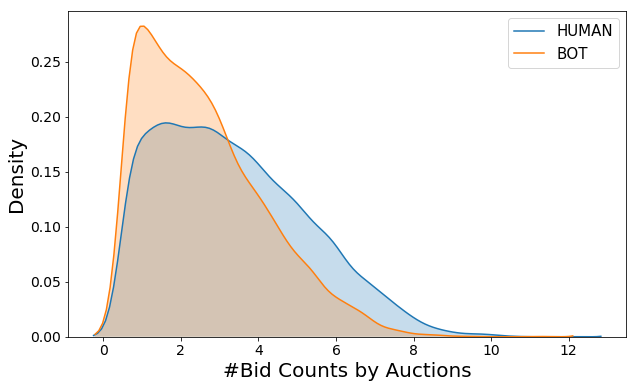

In [58]:
import math

def get_log(num):
    return math.log(num)

bid_count_auction = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).size().reset_index(name = "bid_count")).dropna()

bid_count_auction['log'] = list(map(get_log, bid_count_auction['bid_count']))
final_bidder_outcome_df = bid_count_auction[bid_count_auction['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('#Bid Counts by Auctions',fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('bid_count_auction.png') 

__Log distribution plot of IP counts by auctions__

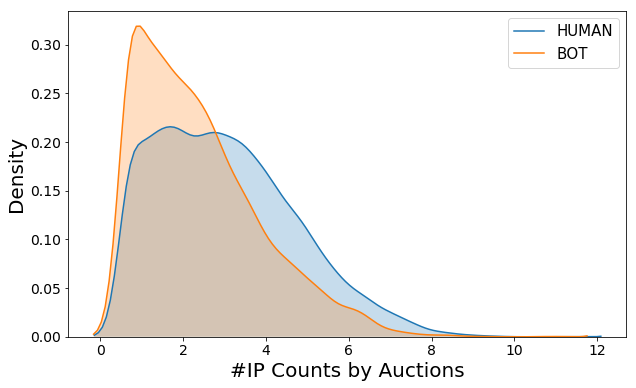

In [40]:
ip_counts = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).ip.nunique().reset_index(name = "ip_counts")).dropna()

ip_counts['log'] = list(map(get_log, ip_counts['ip_counts']))
final_bidder_outcome_df = ip_counts[ip_counts['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('#IP Counts by Auctions', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('ip_count_auction.png') 


__Log distribution plot of merchandise counts by auctions__

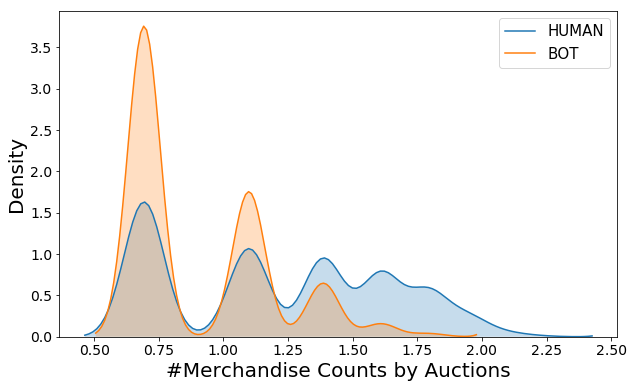

In [41]:
merc_counts = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).merchandise.nunique().reset_index(name = "merc_counts")).dropna()

merc_counts['log'] = list(map(get_log, merc_counts['merc_counts']))
final_bidder_outcome_df = merc_counts[merc_counts['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('#Merchandise Counts by Auctions', fontsize = 20)
plt.ylabel('Density',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('merc_count_auction.png') 

__Merchandise where Human and Bots are bidding__

In [57]:
merchandise = pd.DataFrame(df_bids_outcome.groupby(['outcome','merchandise']).size().reset_index(name = "bid_count")).dropna()
merchandise.loc[merchandise.outcome == 0].sort_values(by='bid_count', ascending=False)
plt.savefig('table') 

<Figure size 432x288 with 0 Axes>

In [43]:
merchandise.loc[merchandise.outcome == 1].sort_values(by='bid_count', ascending=False)

,outcome,merchandise,bid_count
16,1.0,sporting goods,230326
14,1.0,mobile,105138
13,1.0,jewelry,37101
12,1.0,home goods,18708
11,1.0,computers,11667
15,1.0,office equipment,7967
10,1.0,books and music,1509
